# ViT Transfer Learning
## vit-base-patch16-224
### Importación de librerías

In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor, default_data_collator
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

### Imagen de prueba

In [2]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

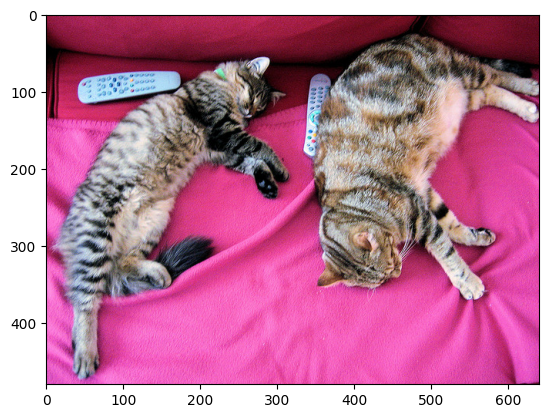

In [3]:
# show the image
plt.imshow(image)

### Prueba del modelo

In [4]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [5]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


---
### id2labels

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv('data/train.csv')

In [6]:
# replace the path_img from images/* tp images/all_imgs/*
train_df['path_img'] = train_df['path_img'].apply(lambda x: x.replace('images/', 'images/all_imgs/'))

In [7]:
train_df

,idx_train,path_img,label
0,0,images/all_imgs/bc7696f4-1460-4d0b-a63d-f84b3b...,0
1,1,images/all_imgs/f8d50663-60d8-4da5-a8b8-79f954...,2
2,2,images/all_imgs/51df0f29-758b-4741-ab74-a0ff8e...,4
3,3,images/all_imgs/f61b81d3-3b79-4162-b4d6-4f1b39...,0
4,4,images/all_imgs/b21e0668-bd09-4794-9e90-da8ecf...,0
...,...,...,...
11195,11195,images/all_imgs/b834c3fa-4fb0-4e38-ae32-7fd4a4...,2
11196,11196,images/all_imgs/b93165ab-a87d-4ee1-8360-9b9728...,6
11197,11197,images/all_imgs/a130fcbb-2b90-4922-b1e2-4770fd...,5
11198,11198,images/all_imgs/bf402d68-ca0b-47f2-86f9-6e81d4...,7


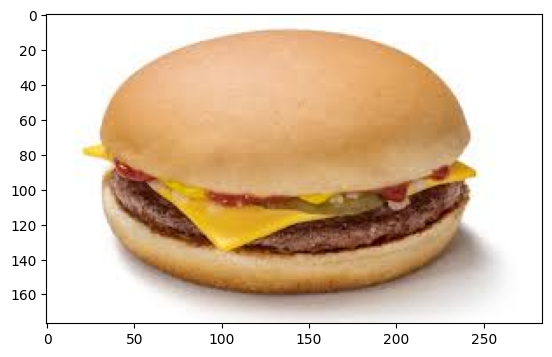

In [8]:
img = Image.open(train_df['path_img'][0])
plt.imshow(img)

In [13]:
sorted(train_df.label.unique())

[0, 1, 2, 3, 4, 5, 6, 7]

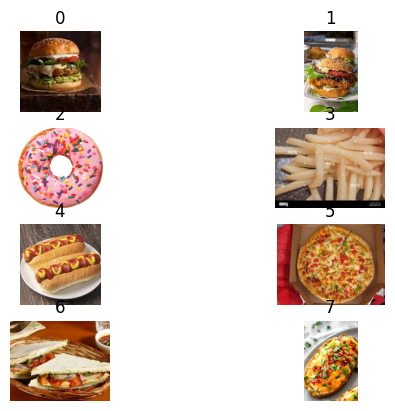

In [25]:
# mostrar una imagen de cada clase en un plot 4x2
for i in sorted(train_df.label.unique()):
    img = Image.open(train_df[train_df.label == i]['path_img'].iloc[10])
    plt.subplot(4, 2, i+1)
    plt.imshow(img)
    plt.title(i)
    plt.axis('off')

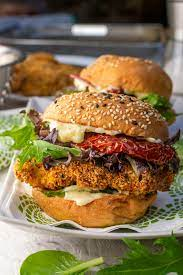

In [29]:
# mostrar la imagen n 10 del id 1
img = Image.open(train_df[train_df.label == 1]['path_img'].iloc[10])
img

In [2]:
id2label = {0: 'Burger', 1: 'Fried Chicken', 2: 'Donut', 3: 'French Fries', 4: 'Hot Dog', 5: 'Pizza', 6: 'Sandwiches', 7: 'Rost Potatoes'}

---
### Transfer Learning - Att. 1

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTForImageClassification, AdamW

In [27]:
# Load the dataset
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

In [28]:
# change all the paths from images/* to images/all_imgs/*
train_df["path_img"] = train_df["path_img"].apply(lambda x: "images/all_imgs/" + x.split("/")[-1])
val_df["path_img"] = val_df["path_img"].apply(lambda x: "images/all_imgs/" + x.split("/")[-1])
test_df["path_img"] = test_df["path_img"].apply(lambda x: "images/all_imgs/" + x.split("/")[-1])

In [29]:
train_df

,idx_train,path_img,label
0,0,images/all_imgs/bc7696f4-1460-4d0b-a63d-f84b3b...,0
1,1,images/all_imgs/f8d50663-60d8-4da5-a8b8-79f954...,2
2,2,images/all_imgs/51df0f29-758b-4741-ab74-a0ff8e...,4
3,3,images/all_imgs/f61b81d3-3b79-4162-b4d6-4f1b39...,0
4,4,images/all_imgs/b21e0668-bd09-4794-9e90-da8ecf...,0
...,...,...,...
11195,11195,images/all_imgs/b834c3fa-4fb0-4e38-ae32-7fd4a4...,2
11196,11196,images/all_imgs/b93165ab-a87d-4ee1-8360-9b9728...,6
11197,11197,images/all_imgs/a130fcbb-2b90-4922-b1e2-4770fd...,5
11198,11198,images/all_imgs/bf402d68-ca0b-47f2-86f9-6e81d4...,7


In [30]:
# Split into input features and target variables
train_paths, train_labels = train_df["path_img"].tolist(), train_df["label"].tolist()
val_paths, val_labels = val_df["path_img"].tolist(), val_df["label"].tolist()
test_paths, test_labels = test_df["path_img"].tolist(), test_df["label"].tolist()

In [31]:
# Load and preprocess the images
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

In [32]:
class FoodImageDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(image_path)
        inputs = self.processor(images=image, return_tensors="pt")
        
        return inputs, label

In [33]:
train_dataset = FoodImageDataset(train_paths, train_labels, processor)
val_dataset = FoodImageDataset(val_paths, val_labels, processor)
test_dataset = FoodImageDataset(test_paths, test_labels, processor)

In [34]:
train_dataset[0]

({'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]])},
 0)

In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [44]:
# Define the model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=8, ignore_mismatched_sizes=True)

# Define the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Define the image processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Set the device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
model.to(device)
print("Using device:", device)

Using device: mps


In [13]:
for epoch in range(10):
    model.train()
    for inputs, labels in train_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = logits.argmax(dim=-1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.shape[0]
        
        accuracy = total_correct / total_samples
        print(f"Epoch {epoch}: Val Accuracy = {accuracy:.3f}")

RuntimeError: Error(s) in loading state_dict for ViTForImageClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([1000, 768]) from checkpoint, the shape in current model is torch.Size([8, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([8]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [ ]:
# Evaluate the model on the test set
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        predictions = logits.argmax(dim=-1)
        total_correct += (predictions == labels).sum().item()
        total_samples

---
### Transfer learning - Att. 2

In [46]:
huggingface_model = 'google/vit-base-patch16-224-in21k'

In [53]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
from transformers import ViTFeatureExtractor, ViTForImageClassification

trainer = VisionClassifierTrainer(
	model_name   = "HF_ViT",
	train        = train_df,
	test         = test_df,
	output_dir   = "./out/",
	max_epochs   = 20,
	batch_size   = 32, # On RTX 2080 Ti
	lr	     = 2e-5,
	fp16	     = True,
	model = ViTForImageClassification.from_pretrained(
	    huggingface_model,
	    num_labels = 8,
	).to('mps') ,
	feature_extractor = ViTFeatureExtractor.from_pretrained(
		huggingface_model,
	),
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7'}
{'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4, 'LABEL_5': 5, 'LABEL_6': 6, 'LABEL_7': 7}


/Users/ismael/.pyenv/versions/3.10.6/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA devices.

In [ ]:
ref, hyp = trainer.evaluate_f1_score()

---
### Transfer learning - Att. 3

In [57]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [56]:
classifier = pipeline(task="image-classification", model="google/vit-base-patch16-224-in21k", tokenizer="google/vit-base-patch16-224-in21k")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---
### Transfer learning - Att. 4

In [3]:
import math
import matplotlib.pyplot as plt
import shutil
#from getpass import getpass
from PIL import Image
# from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

Transform current data to desired format

In [39]:
# load train and test dataset
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
# join train and test dataset
df = pd.concat([train_df, test_df], axis=0)
# drop idx_train and idx_test columns
df.drop(["idx_train", "idx_test"], axis=1, inplace=True)
# change image path from images/* to images/all_imgs/*
df["path_img"] = df["path_img"].apply(lambda x: "images/all_imgs/" + x.split("/")[-1])

In [ ]:
id2label = {0: 'Burger', 1: 'Fried Chicken', 2: 'Donut', 3: 'French Fries', 4: 'Hot Dog', 5: 'Pizza', 6: 'Sandwiches', 7: 'Rost Potatoes'}

In [42]:
# replace labels with id2label
df["label"] = df["label"].apply(lambda x: id2label[x])

In [44]:
df.groupby("label").count()

,path_img
label,
Burger,2000
Donut,2000
French Fries,2000
Fried Chicken,2000
Hot Dog,2000
Pizza,2000
Rost Potatoes,2000
Sandwiches,2000


In [46]:
# create a folder for each label in the path "images/all_imgs/treated"
for label in df["label"].unique():
    Path(f"images/all_imgs/treated/{label}").mkdir(parents=True, exist_ok=True)

In [49]:
df.iloc[2]["path_img"]

'images/all_imgs/51df0f29-758b-4741-ab74-a0ff8e21c044.jpeg'

In [51]:
# save each image in a folder with its label
not_found = []

for i in range(len(df)):
    img_path = df.iloc[i]["path_img"]
    label = df.iloc[i]["label"]
    filename = img_path.split("/")[-1]
    try:
        shutil.copy(img_path, f"images/all_imgs/treated/{label}/{filename}")
    except FileNotFoundError:
        not_found.append(img_path)

In [68]:
print('Files not found:', len(not_found))
# show files not found in the dataset
df[df["path_img"].isin(not_found)]

Files not found: 13


,path_img,label
174,images/all_imgs/e1da2c83-cd6f-4d1b-8955-621d02...,Hot Dog
931,images/all_imgs/9a397c3e-1929-4039-bb8b-94d77c...,Hot Dog
1336,images/all_imgs/72be3d8a-c785-4a39-99ca-cc12d5...,Pizza
1473,images/all_imgs/eced1373-71d4-404e-aa52-c75189...,Hot Dog
6263,images/all_imgs/0795b1c2-3730-4851-866a-6a59e6...,Hot Dog
6806,images/all_imgs/4a7744b3-a97d-4411-bb9c-238537...,Donut
8136,images/all_imgs/45fdaed0-fabc-4b0f-90cc-2105fe...,Hot Dog
8418,images/all_imgs/516d9565-2d4a-49f2-9766-223446...,Burger
9065,images/all_imgs/45c66c87-8dd6-4743-a8d0-a99a11...,French Fries
10237,images/all_imgs/9cd58fd7-172c-45b9-8034-648d85...,Donut


Done transforming data

In [4]:
data_dir = Path("images/all_imgs/treated")
data_dir

PosixPath('images/all_imgs/treated')

In [5]:
# initialize dataset and split it into train and validation
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(ds) * 0.2)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

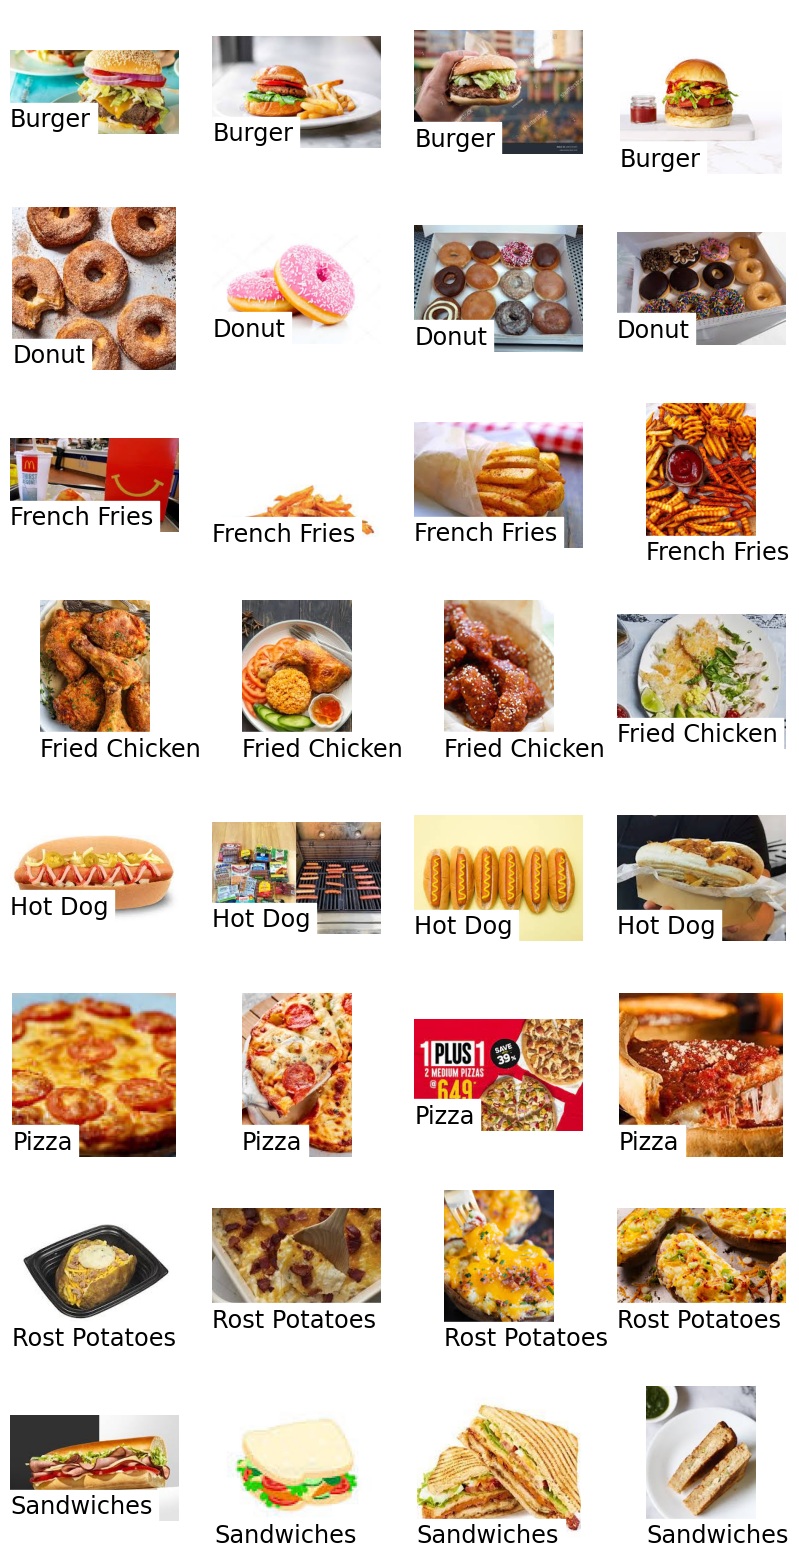

In [6]:
# Show some images
plt.figure(figsize=(10,20))
num_examples_per_class = 4
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [7]:
# preparing labels
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [8]:
label2id

{'Burger': '0',
 'Donut': '1',
 'French Fries': '2',
 'Fried Chicken': '3',
 'Hot Dog': '4',
 'Pizza': '5',
 'Rost Potatoes': '6',
 'Sandwiches': '7'}

In [9]:
id2label

{'0': 'Burger',
 '1': 'Donut',
 '2': 'French Fries',
 '3': 'Fried Chicken',
 '4': 'Hot Dog',
 '5': 'Pizza',
 '6': 'Rost Potatoes',
 '7': 'Sandwiches'}

In [10]:
# image classification collator
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [15]:
# Initialize feature extractor, model and data loaders
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator)

/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification wer

In [16]:
# Training
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [17]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='auto', devices=1, precision=16, max_epochs=4)

Global seed set to 42
/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(classifier, train_loader, val_loader)


  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | MulticlassAccuracy        | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.219   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/torchmetrics/functional/classification/accuracy.py:65: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)
/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

Training: 0it [00:00, ?it/s]

/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [19]:
# check the results
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([5, 2, 7, 1, 6, 3, 7, 5])
Labels: tensor([5, 2, 7, 1, 6, 3, 7, 5])


In [20]:
# save the model
model.save_pretrained('models/vit-base-patch16-224-in21k')

In [26]:
# save checkpoint
trainer.save_checkpoint('models/vit-base-patch16-224-in21k/checkpoint.ckpt')

Test/evaluate the model

In [24]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [31]:
# get predictions
preds = []
labels = []

for batch in val_loader:
    print(f'Batch {len(preds) + 1}/{len(val_loader)}', end='\r')
    outputs = model(**batch)
    preds.append(outputs.logits.softmax(1).argmax(1))
    labels.append(batch['labels'])

In [32]:
preds = torch.cat(preds)
labels = torch.cat(labels)

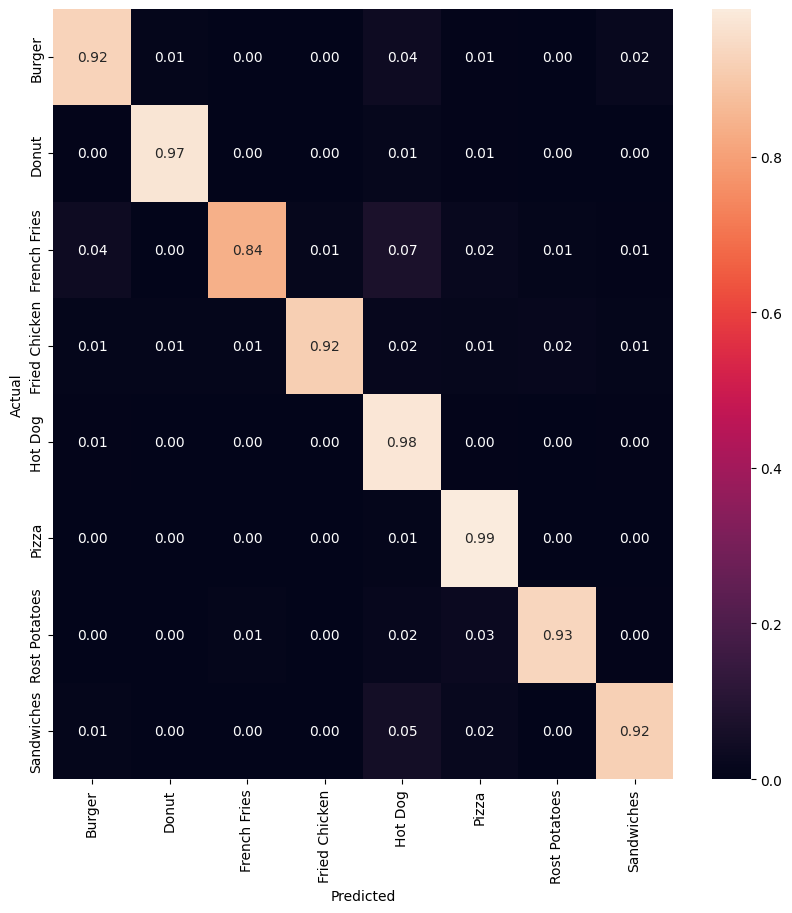

In [33]:
# create confusion matrix
cm = confusion_matrix(labels, preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=ds.classes, yticklabels=ds.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
# f1 score
from sklearn.metrics import f1_score

f1_score(labels, preds, average='weighted')

0.9339694784570948

Visualize the model

In [41]:
# assess the model using tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
%tensorboard --logdir lightning_logs/